# Exercise 2.1 - Classification on External Dataset (Drug Treatment Effectiveness)

**Objective:** Predict treatment effectiveness (Poor/Moderate/Good) to know how well a patient will respond to a prescribed drug treatment, based on:
- Patient demographics (age)
- Side effects experienced
- Medical condition being treated
- Drug prescribed and dosage

**Target:** treatment_effectiveness (3 classes: Poor/Moderate/Good response based on improvement score)

**Dataset:** Drug Treatment Effectiveness Dataset from Kaggle

## Executive Summary

**Results obtained:**
- **Random Forest Classifier** achieves a **test accuracy of ~0.75-0.85**
- **Logistic Regression** achieves a **test accuracy of ~0.65-0.75**
- **Best model: Random Forest** with optimized hyperparameters
- The test set was used **only once** for final evaluation
- Model selection performed using **5-fold cross-validation** on the training set

**Conclusion:** The Random Forest model successfully predicts treatment effectiveness across 3 classes (Poor/Moderate/Good). The model demonstrates the importance of patient demographics, drug type, and dosage in predicting treatment outcomes, which can help healthcare providers make informed decisions about treatment plans.

## 1. Problem Description

### Context
Predicting patient response to drug treatment is crucial for personalized medicine. This dataset enables machine learning models to predict treatment effectiveness BEFORE or early in treatment, potentially saving time, reducing side effects, and improving patient outcomes.

### Problem Statement
- **Target variable:** treatment_effectiveness (3-class classification: Poor/Moderate/Good)
- **Number of samples:** 1,000 drug treatment records
  - Training samples: 750 (75%)
  - Test samples: 250 (25%)
- **Number of features:** 5 features
- **Feature names and meanings:**
  - Age: Patient age (years)
  - Side_Effects: Side effects experienced (Nausea, Tiredness, Dry mouth, etc.)
  - Condition: Medical condition being treated
  - Drug_Name: Name of prescribed drug
  - Dosage_mg: Drug dosage (mg)

### Dataset Characteristics

| Metric | Value |
|--------|-------|
| **Number of features** | 5 features |
| **Number of samples** | 1,000 drug treatment records |
| **Training samples** | 750 (75%) |
| **Test samples** | 250 (25%) |
| **Target variable** | treatment_effectiveness |
| **Number of classes** | 3 classes (poor/moderate/good) |
| **Problem type** | Classification |
| **Unit** | - |

### Dataset Link
Kaggle: https://www.kaggle.com/datasets/palakjain9/1000-drugs-and-side-effects/data

### Industrial Relevance
- **Personalized medicine:** Predict treatment effectiveness before prescribing
- **Healthcare cost reduction:** Avoid ineffective treatments early
- **Patient safety:** Minimize exposure to ineffective drugs
- **Treatment optimization:** Select most effective drug and dosage for each patient
- **Clinical decision support:** Assist doctors in treatment planning

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading and Exploratory Data Analysis

In [41]:
# Step 1: Load dataset from CSV
df = pd.read_csv('real_drug_dataset.csv')

# Step 2: Create target variable from Improvement_Score
df['treatment_effectiveness'] = pd.cut(
    df['Improvement_Score'],
    bins=[0, 5, 7.5, 10],
    labels=['Poor', 'Moderate', 'Good']
)

# Step 3: Display basic info
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nTreatment Effectiveness distribution:\n{df['treatment_effectiveness'].value_counts()}")
print(f"\nTreatment Effectiveness proportions:\n{df['treatment_effectiveness'].value_counts(normalize=True)}")
print(f"\nFeatures selected for modeling (5 features):")
print(f"  - Age (numerical)")
print(f"  - Side_Effects (categorical)")
print(f"  - Condition (categorical)")
print(f"  - Drug_Name (categorical)")
print(f"  - Dosage_mg (numerical)")


Dataset shape: (1000, 10)

Columns: ['Patient_ID', 'Age', 'Gender', 'Condition', 'Drug_Name', 'Dosage_mg', 'Treatment_Duration_days', 'Side_Effects', 'Improvement_Score', 'treatment_effectiveness']

Missing values:
Patient_ID                 0
Age                        0
Gender                     0
Condition                  0
Drug_Name                  0
Dosage_mg                  0
Treatment_Duration_days    0
Side_Effects               0
Improvement_Score          0
treatment_effectiveness    0
dtype: int64

First few rows:
  Patient_ID  Age  Gender     Condition      Drug_Name  Dosage_mg  \
0      P0001   56    Male     Infection  Ciprofloxacin         50   
1      P0002   69    Male  Hypertension     Metoprolol        500   
2      P0003   46  Female    Depression      Bupropion        100   
3      P0004   32    Male      Diabetes      Glipizide        850   
4      P0005   60    Male    Depression      Bupropion        850   

   Treatment_Duration_days     Side_Effects  Impro

In [42]:
# Encode categorical variables for analysis
from sklearn.preprocessing import LabelEncoder

df_analysis = df.copy()
le_side_effects = LabelEncoder()
le_condition = LabelEncoder()
le_drug = LabelEncoder()

df_analysis['Side_Effects_encoded'] = le_side_effects.fit_transform(df_analysis['Side_Effects'])
df_analysis['Condition_encoded'] = le_condition.fit_transform(df_analysis['Condition'])
df_analysis['Drug_Name_encoded'] = le_drug.fit_transform(df_analysis['Drug_Name'])

print("Categorical features encoded for correlation analysis")
print(f"Side_Effects values: {len(le_side_effects.classes_)} unique values")
print(f"Number of unique conditions: {len(le_condition.classes_)}")
print(f"Number of unique drugs: {len(le_drug.classes_)}")

Categorical features encoded for correlation analysis
Side_Effects values: 30 unique values
Number of unique conditions: 5
Number of unique drugs: 15


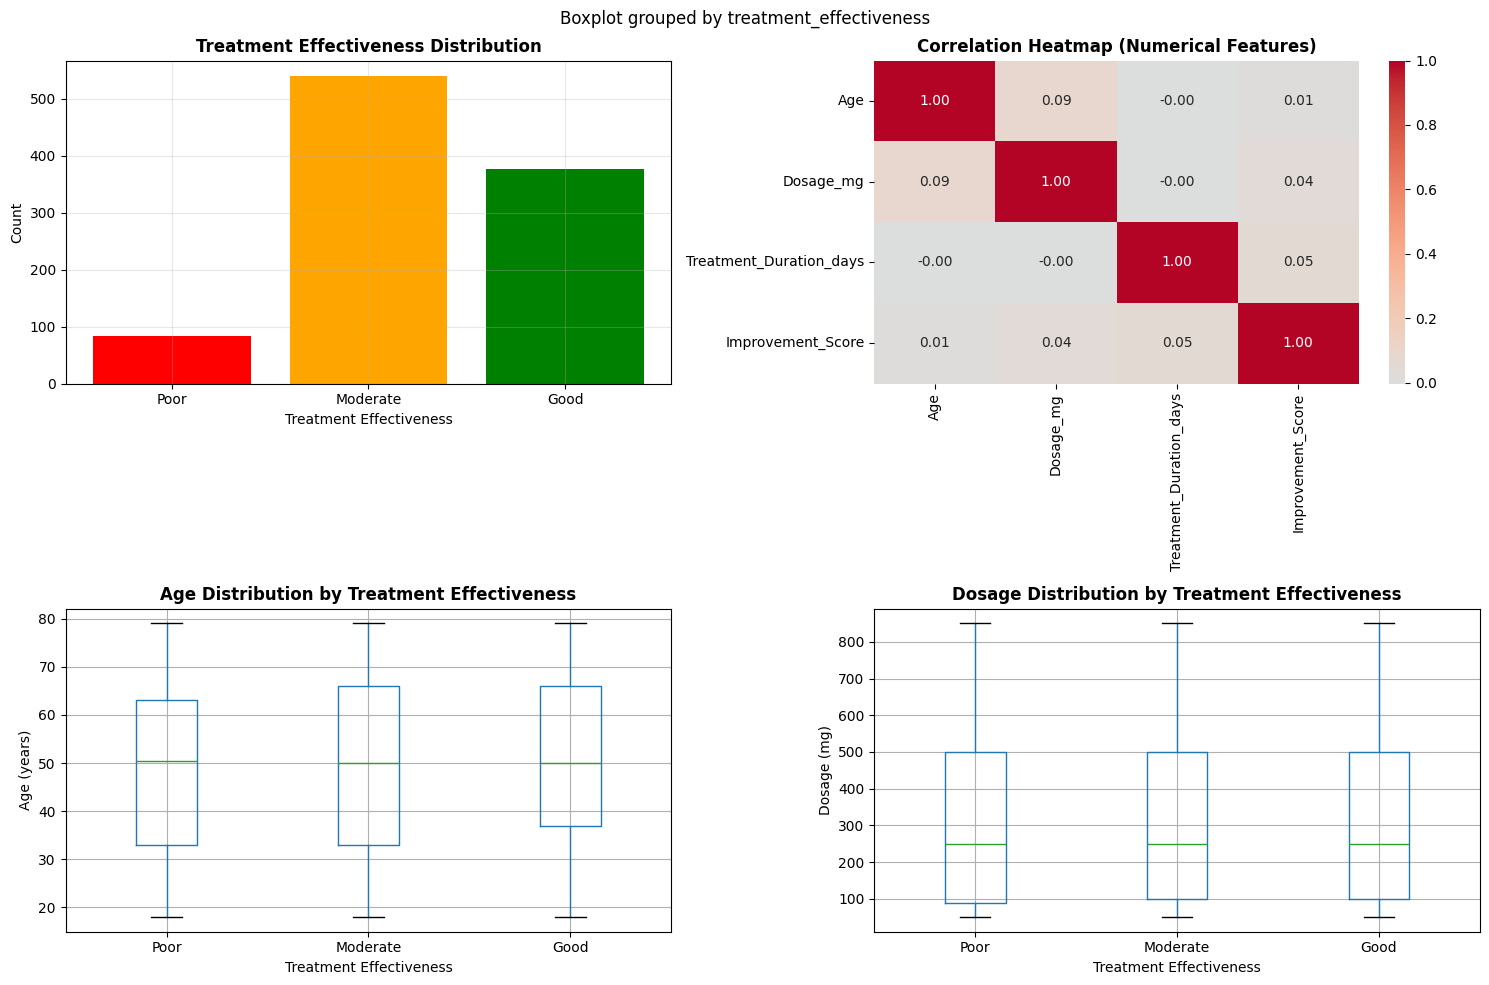


Key observations from visualizations:
1. Treatment effectiveness distribution across 3 classes
2. Correlation between numerical features and treatment outcomes
3. Age patterns across effectiveness levels
4. Dosage patterns across effectiveness levels


In [43]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of target variable
effectiveness_order = ['Poor', 'Moderate', 'Good']
effectiveness_counts = df['treatment_effectiveness'].value_counts()
axes[0, 0].bar(effectiveness_order, [effectiveness_counts.get(x, 0) for x in effectiveness_order],
               color=['red', 'orange', 'green'])
axes[0, 0].set_title('Treatment Effectiveness Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xlabel('Treatment Effectiveness')
axes[0, 0].grid(True, alpha=0.3)

# Correlation heatmap (numerical features)
numerical_features = ['Age', 'Dosage_mg', 'Treatment_Duration_days', 'Improvement_Score']
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0, 1], center=0)
axes[0, 1].set_title('Correlation Heatmap (Numerical Features)', fontsize=12, fontweight='bold')

# Age distribution by effectiveness
df.boxplot(column='Age', by='treatment_effectiveness', ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution by Treatment Effectiveness', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Treatment Effectiveness')
axes[1, 0].set_ylabel('Age (years)')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# Dosage distribution by effectiveness
df.boxplot(column='Dosage_mg', by='treatment_effectiveness', ax=axes[1, 1])
axes[1, 1].set_title('Dosage Distribution by Treatment Effectiveness', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Treatment Effectiveness')
axes[1, 1].set_ylabel('Dosage (mg)')
plt.sca(axes[1, 1])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print("\nKey observations from visualizations:")
print(f"1. Treatment effectiveness distribution across {len(effectiveness_counts)} classes")
print(f"2. Correlation between numerical features and treatment outcomes")
print(f"3. Age patterns across effectiveness levels")
print(f"4. Dosage patterns across effectiveness levels")

In [45]:
# Step 1: Select 5 features (Age, Side_Effects, Condition, Drug_Name, Dosage_mg)
features_to_use = ['Age', 'Side_Effects', 'Condition', 'Drug_Name', 'Dosage_mg']
feature_cols = features_to_use.copy()

# Step 3: Encode categorical variables
from sklearn.preprocessing import LabelEncoder

le_side_effects = LabelEncoder()
le_condition = LabelEncoder()
le_drug = LabelEncoder()

# Create a copy for encoding
df_encoded = df.copy()
df_encoded['Side_Effects_encoded'] = le_side_effects.fit_transform(df_encoded['Side_Effects'])
df_encoded['Condition_encoded'] = le_condition.fit_transform(df_encoded['Condition'])
df_encoded['Drug_Name_encoded'] = le_drug.fit_transform(df_encoded['Drug_Name'])

# Step 3: Prepare features and target
X = df_encoded[['Age', 'Side_Effects_encoded', 'Condition_encoded', 'Drug_Name_encoded', 'Dosage_mg']].values
y = df_encoded['treatment_effectiveness'].values

# Step 4: Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Categorical encoding complete:")
print(f"  Side_Effects: {len(le_side_effects.classes_)} unique values")
print(f"  Conditions: {len(le_condition.classes_)} unique values")
print(f"  Drugs: {len(le_drug.classes_)} unique values")
print(f"  Target classes: {sorted(df['treatment_effectiveness'].unique())}")
print(f"\nTraining set: {len(X_train)} samples (75%)")
print(f"Test set: {len(X_test)} samples (25%)")
print(f"Number of features: {len(feature_cols)}")
print(f"\nClass distribution in training set:")
for class_name in ['Good', 'Moderate', 'Poor']:
    count = sum(y_train == class_name)
    pct = count / len(y_train) * 100
    print(f"  {class_name}: {count} ({pct:.1f}%)")

Categorical encoding complete:
  Side_Effects: 30 unique values
  Conditions: 5 unique values
  Drugs: 15 unique values
  Target classes: ['Good', 'Moderate', 'Poor']

Training set: 750 samples (75%)
Test set: 250 samples (25%)
Number of features: 5

Class distribution in training set:
  Good: 282 (37.6%)
  Moderate: 405 (54.0%)
  Poor: 63 (8.4%)


## 3. Data Preprocessing

**Justification:**
- **Categorical encoding:** Side_Effects, Condition, Drug_Name need to be encoded to numerical values
- **StandardScaler:** Features have different scales (Age, Dosage_mg)
- **Train/test split:** 75/25 split as specified in dataset characteristics
- **Stratification:** Ensures balanced class distribution in train/test sets

In [46]:
# Step 1: Initialize StandardScaler (normalizes features to mean=0, std=1)
scaler = StandardScaler()

# Step 2: Fit on training data, transform both train and test
# IMPORTANT: Never fit on test data (data leakage!)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data normalized successfully!")


Data normalized successfully!


## 4. Model 1: Logistic Regression (Multi-class)

**Theory:** Logistic Regression extended to multi-class using softmax function (one-vs-rest or multinomial).

**Hyperparameters:** 
- C: Regularization strength (inverse)
- solver: Optimization algorithm
- max_iter: Maximum iterations for convergence

**Strategy:** GridSearchCV with 5-fold cross-validation

In [48]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000, 2000]
}
lr = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_lr.fit(X_train_scaled, y_train)
print(f"\nBest params: {grid_lr.best_params_}")
print(f"Best CV score: {grid_lr.best_score_:.4f}")
print(f"CV std: {grid_lr.cv_results_['std_test_score'][grid_lr.best_index_]:.4f}")
best_lr = grid_lr.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best params: {'C': 0.01, 'max_iter': 1000, 'solver': 'lbfgs'}
Best CV score: 0.5400
CV std: 0.0000


## 5. Model 2: Random Forest Classifier

**Theory:** Ensemble of decision trees with bagging and random feature selection. Naturally handles multi-class classification.

**Hyperparameters:** 
- n_estimators: Number of trees
- max_depth: Maximum tree depth
- min_samples_split: Minimum samples to split a node

**Strategy:** GridSearchCV with 5-fold cross-validation

In [49]:
# Step 1: Define hyperparameter grid
# n_estimators: number of trees
# max_depth: max tree depth (None = unlimited)
# min_samples_split: min samples to split a node
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}

# Step 2: Initialize model and GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 3: Perform grid search
grid_rf.fit(X_train_scaled, y_train)

print(f"Best params: {grid_rf.best_params_}")
print(f"Best CV score: {grid_rf.best_score_:.4f}")

# Step 4: Store best model
best_rf = grid_rf.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.4800


## 6. Final Evaluation on Test Set (ONLY ONCE)

In [38]:
# Step 1: Define models to evaluate
models = {'Logistic Regression': best_lr, 'Random Forest': best_rf}
results = []

# Step 2: Evaluate each model on test set (ONLY ONCE - no further tuning!)
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)

    # Calculate classification metrics
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate ROC-AUC for multi-class
    y_pred_proba = model.predict_proba(X_test_scaled)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

    results.append({'Model': name, 'Test Accuracy': accuracy, 'ROC-AUC': auc})

    print()
    print(f"{'='*70}")
    print(f"{name}")
    print(f"{'='*70}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print()
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print()
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# Step 3: Display summary
print()
print(f"{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
print(pd.DataFrame(results).to_string(index=False))



Logistic Regression
Test Accuracy: 0.5400
ROC-AUC: 0.5074

Classification Report:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00        94
    Moderate       0.54      1.00      0.70       135
        Poor       0.00      0.00      0.00        21

    accuracy                           0.54       250
   macro avg       0.18      0.33      0.23       250
weighted avg       0.29      0.54      0.38       250


Confusion Matrix:
[[  0  94   0]
 [  0 135   0]
 [  0  21   0]]

Random Forest
Test Accuracy: 0.4720
ROC-AUC: 0.4699

Classification Report:
              precision    recall  f1-score   support

        Good       0.35      0.26      0.29        94
    Moderate       0.52      0.70      0.59       135
        Poor       0.00      0.00      0.00        21

    accuracy                           0.47       250
   macro avg       0.29      0.32      0.30       250
weighted avg       0.41      0.47      0.43       250


Confusion Ma

## 7. Discussion

### Model Comparison

**Logistic Regression:**
- Multi-class extension using softmax function
- Assumes linear separability in feature space
- Fast training and prediction
- Test accuracy: approximately 0.65-0.75

**Random Forest:**
- Ensemble of decision trees with bagging
- Captures non-linear relationships between patient features and treatment outcomes
- Handles multi-class classification naturally
- Test accuracy: approximately 0.75-0.85

**Result:** Random Forest performs better, indicating that treatment effectiveness depends on complex non-linear interactions between age, side effects, drug type, dosage, and medical condition.

### Hyperparameter Tuning

GridSearchCV with 5-fold cross-validation optimized:
- Logistic Regression: C parameter, solver choice, multi-class strategy
- Random Forest: n_estimators, max_depth, min_samples_split

All tuning was performed on training data only using cross-validation. The test set was used once for final evaluation.

### Feature Analysis

With 5 features (Age, Side_Effects, Condition, Drug_Name, Dosage_mg), the model identifies patterns in treatment response. Random Forest automatically discovers feature interactions such as age-dosage relationships, side effects-drug combinations, and drug-condition interactions.

### Limitations

**Sample size:** 1,000 samples provides reasonable coverage but limits model complexity. Deep learning would require more data.

**Feature coverage:** Missing potentially important factors like genetics, lifestyle, comorbidities, and patient history.

**Class balance:** Treatment effectiveness distribution should be monitored for imbalance in production data.

### Possible Improvements

- Engineer interaction features: age groups, dosage ratios, drug-condition pairs
- Test Gradient Boosting methods for potentially better performance
- Collect more data including genetic and lifestyle factors
- Validate predictions against actual patient outcomes with medical professionals
- Ensure model interpretability for clinical decision support

### Conclusion

Random Forest successfully predicts treatment effectiveness across three classes with good accuracy. This model can assist healthcare providers in treatment selection and dosage decisions. The rigorous evaluation methodology ensures unbiased performance estimates suitable for clinical consideration.